In [21]:
from colpali_engine.models import ColFlor
from colpali_engine.models import ColFlorProcessor
from colpali_engine.utils.processing_utils import BaseVisualRetrieverProcessor
from colpali_engine.utils.torch_utils import ListDataset, get_torch_device
import torch
from typing import List, cast

c:\Users\saura\miniconda3\envs\COLFLOR\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [22]:
device = get_torch_device("auto")
print(f"Device used: {device}")

Device used: cuda:0


In [23]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.version.cuda)  # Should match CUDA version
print(torch.backends.cudnn.version())  # Should return cuDNN version


True
12.4
90100


In [24]:
model_name = "ahmed-masry/ColFlor"

# Load model
model = ColFlor.from_pretrained(
    model_name,
    #torch_dtype=torch.bfloat16,
    device_map=device,
).eval()

In [25]:
processor = ColFlorProcessor.from_pretrained(model_name)

In [14]:
from PIL import Image

image_path = r"C:\Users\saura\Pictures\7290_proposal.png"

# Open the image
image = Image.open(image_path)

# # Display the image (optional)
# image.show()

In [16]:
data = processor.process_images([image])

In [20]:
data.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'full_attention_mask'])

In [23]:
ds: List[torch.Tensor] = []
with torch.no_grad():
    batch_doc = {k: v.to(model.device) for k, v in data.items()}
    embeddings_doc = model(**batch_doc)
    print(embeddings_doc.shape)
ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))


torch.Size([1, 587, 128])


In [26]:
from pdf2image import convert_from_path
pages = convert_from_path(r"F:\MS files\Course\CS7290\project\VisionRAG\asset\Chubb-Limited-Investor-Presentation-December-2023.pdf", poppler_path=r"C:\Users\saura\poppler-24.08.0\Library\bin")

In [27]:
data = processor.process_images(pages)
ds: List[torch.Tensor] = []

with torch.no_grad():
    batch_doc = {k: v.to(model.device) for k, v in data.items()}
    embeddings_doc = model(**batch_doc)
    
    print(embeddings_doc.shape)
ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

torch.Size([35, 587, 128])


In [31]:
ds[0]

tensor([[-0.0157,  0.0849, -0.0257,  ..., -0.2507,  0.0864,  0.1317],
        [-0.0066,  0.0899, -0.0483,  ..., -0.2438,  0.0753,  0.1247],
        [-0.0083,  0.0907, -0.0445,  ..., -0.2458,  0.0787,  0.1249],
        ...,
        [-0.0267,  0.0178,  0.0234,  ...,  0.0290,  0.0528,  0.1370],
        [-0.1165,  0.0698,  0.0272,  ...,  0.0290,  0.1768,  0.0944],
        [-0.1129,  0.0480,  0.0732,  ...,  0.1011,  0.1718,  0.1023]])

In [ ]:
len(ds[0])

587

## Test DB

In [14]:
import psycopg2
import numpy as np

# Connect to your database
conn = psycopg2.connect(
    dbname="vision_rag",
    user="admin",
    password="admin",
    host="localhost"
)
# # Create a table with a vector column
# with conn.cursor() as cur:
#     cur.execute("""
#         CREATE TABLE items (
#             id serial PRIMARY KEY,
#             embedding vector(3)
#         );
#     """)
#     conn.commit()

In [19]:
import psycopg2
from psycopg2.extras import execute_values

def store_page_embeddings(filename, page_embeddings):
    """
    Stores the embeddings of each page in the PostgreSQL database.

    :param filename: Name of the document file.
    :param page_embeddings: List of tuples, each containing the page number and its embedding vector.
    """
    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname="vision_rag",
        user="admin",
        password="admin",
        host='localhost',
        port='5432'
    )
    cursor = conn.cursor()

    # Prepare data for insertion
    records = [(filename, page_embeddings)]

    # Insert records into the database
    insert_query = """
        INSERT INTO documents (filename, embedding)
        VALUES %s
    """
    execute_values(cursor, insert_query, records)

    # Commit and close connection
    conn.commit()
    cursor.close()
    conn.close()


In [43]:
embeddings_doc.flatten().shape

torch.Size([2629760])

In [44]:
store_page_embeddings("test.pdf", embeddings_doc.cpu().flatten().tolist())

ProgramLimitExceeded: vector cannot have more than 16000 dimensions


## Test hdf5

In [ ]:
import h5py
import numpy as np



In [46]:
store_vector("test.pdf", embeddings_doc.cpu())

In [47]:
def get_vector_by_filename(filename):
    with h5py.File('vectors.h5', 'r') as f:
        if filename in f:
            return f[filename]['vector'][()]
    return None

vector = get_vector_by_filename("test.pdf")

In [49]:
vector.shape

(35, 587, 128)

## Run comparison

In [55]:
text = "What percentage of income came from agriculture sector?"
with torch.no_grad():
    batch_doc = {k: v.to(model.device) for k, v in processor.process_queries([text]).items()}
    text_embed = model(**batch_doc)
text_embed.shape


torch.Size([1, 23, 128])

In [52]:
text_embed

{'input_ids': tensor([[    0, 45641,    35,   305,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,  1368,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,    10,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,   326,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,  1437,  1437,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     2],
        [    0, 45641,    35,   181,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,   364,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     2,     1],
        [    0, 45641,    35,   910,     1,     1,     1,     1,     

## ColQwen2

In [2]:
from flask import Flask, request, jsonify
from typing import Any, List, cast
import h5py
import structlog
from colpali_engine.utils.torch_utils import get_torch_device
from peft import LoraConfig
from PIL import Image
from colqwen2 import ColQwen2ForRAG
from colpali_engine.models import ColQwen2, ColQwen2Processor
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch
import os
from app import process_pdf, store_vector, scale_image, processor_retrieval, model, processor_generation
from pdf2image import convert_from_path
import numpy as np
device = get_torch_device("auto")

Using device: cuda:0


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
pdf_path = r"F:\MS files\Course\CS7290\project\VisionRAG\asset\Chubb-Limited-Investor-Presentation-December-2023-short.pdf"
images, pages = process_pdf(pdf_path)
store_vector("Chubb-Limited-Investor-Presentation-December-2023-short.pdf", pages, images)

In [5]:
query = "Contribution of agriculture sector?"

data = processor_retrieval.process_queries([query])
with torch.no_grad():
    batch_doc = {k: v.to(model.device) for k, v in data.items()}
    embeddings_doc = model(**batch_doc)

embeddings_doc = embeddings_doc.cpu().float().numpy()
embeddings_doc.shape   



(1, 17, 128)

In [3]:
def get_data_by_filename(filename):
    with h5py.File(os.path.join('data','knowledge_base.h5'), 'r') as f:
        if filename in f:
            return f[filename]['vector'][()], f[filename]['image'][()]
    return None

image_embedding, images = get_data_by_filename("Chubb-Limited-Investor-Presentation-December-2023-short.pdf")
image_embedding.shape, images.shape

((3, 35, 128), (3, 125, 161, 3))

In [6]:
scores = processor_retrieval.score_multi_vector(torch.from_numpy(embeddings_doc), torch.from_numpy(image_embedding))

top_pages = scores.numpy()[0].argsort()[-1:][::-1]
top_pages

array([2], dtype=int64)

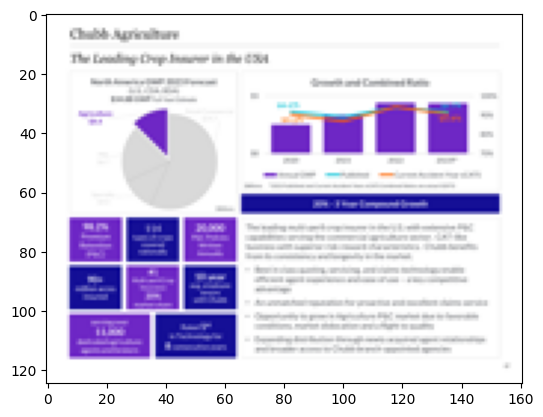

In [7]:
import matplotlib.pyplot as plt
for i in images[top_pages]:
    plt.imshow(i)
    plt.show()

In [8]:
images[top_pages].shape

(1, 125, 161, 3)

In [9]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[images[top_pages][0]],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
print('DoNE')
output_ids = model.generate(**inputs_generation, max_new_tokens=50)
print('DoNE')

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
print('DoNE')

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)
print('DoNE')

print(output_text)

DoNE
DoNE
DoNE
DoNE
['The agriculture sector contributes to the GDP of Chad.']
